##Импортируем библиотеки

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision as tv

import albumentations as A
from albumentations.pytorch import ToTensorV2

import copy
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

<ipython-input-1-5403a2837498>:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


##Создаем архитектуру нейронной сети

In [2]:
class convolution_block(nn.Module):
    def __init__(self, in_channels, out_channels):
      super().__init__()
      self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=True)
      self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=True)
      self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=True)
      self.bn1 = nn.BatchNorm2d(out_channels)
      self.bn2 = nn.BatchNorm2d(out_channels)
      self.bn3 = nn.BatchNorm2d(out_channels)
      self.act = nn.GELU()

    def forward(self, x):
      out = self.conv1(x)
      out = self.bn1(out)
      out = self.act(out)
      out = self.conv2(out)
      out = self.bn2(out)
      out = self.act(out)
      out = self.conv3(out)
      out = self.bn3(out)
      out = self.act(out)
      return out

class upconvolution_block(nn.Module):
    def __init__(self, in_channels, out_channels):
      super().__init__()
      self.convt = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
      out = self.convt(x)
      return out

# Определение U-Net архитектуры
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Кодировщик (Encoder)
        self.conv1 = convolution_block(in_channels, 32)
        self.conv2 = convolution_block(32, 64)
        self.conv3 = convolution_block(64, 128)
        self.conv4 = convolution_block(128, 256)
        self.conv5 = convolution_block(256, 512)


        # Блок наивысшего уровня (Bottleneck)
        self.bottleneck = convolution_block(512, 1024)

        # Декодировщик (Decoder)
        self.upconv4 = upconvolution_block(1024, 512)
        self.conv6 = convolution_block(1024, 512)
        self.upconv3 = upconvolution_block(512, 256)
        self.conv7 = convolution_block(512, 256)
        self.upconv2 = upconvolution_block(256, 128)
        self.conv8 = convolution_block(256, 128)
        self.upconv1 = upconvolution_block(128, 64)
        self.conv9 = convolution_block(128, 64)
        self.upconv0 = upconvolution_block(64, 32)
        self.conv10 = convolution_block(64, 32)

        # Выходной слой
        self.output = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # Прямой проход через кодировщик
        conv1 = self.conv1(x)
        pool1 = nn.MaxPool2d(kernel_size=2)(conv1)
        conv2 = self.conv2(pool1)
        pool2 = nn.MaxPool2d(kernel_size=2)(conv2)
        conv3 = self.conv3(pool2)
        pool3 = nn.MaxPool2d(kernel_size=2)(conv3)
        conv4 = self.conv4(pool3)
        pool4 = nn.MaxPool2d(kernel_size=2)(conv4)
        conv5 = self.conv5(pool4)

        # Прямой проход через блок наивысшего уровня (Bottleneck)
        bottleneck = self.bottleneck(nn.MaxPool2d(kernel_size=2)(conv5))

        # Прямой проход через декодировщик
        upconv4 = self.upconv4(bottleneck)
        concat4 = torch.cat([conv5, upconv4], dim=1)
        conv6 = self.conv6(concat4)
        upconv3 = self.upconv3(conv6)
        concat3 = torch.cat([conv4, upconv3], dim=1)
        conv7 = self.conv7(concat3)
        upconv2 = self.upconv2(conv7)
        concat2 = torch.cat([conv3, upconv2], dim=1)
        conv8 = self.conv8(concat2)
        upconv1 = self.upconv1(conv8)
        concat1 = torch.cat([conv2, upconv1], dim=1)
        conv9 = self.conv9(concat1)
        upconv0 = self.upconv0(conv9)
        concat0 = torch.cat([conv1, upconv0], dim=1)
        conv10 = self.conv10(concat0)


        # Выходной слой
        output = self.output(conv10)

        return output

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Загружаем датасет и нормализуем картинки

In [4]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self,  images_directory, masks_directory, transform=None):
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform

        self.images_filenames = sorted(os.listdir(self.images_directory))

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(self.masks_directory, image_filename), cv2.IMREAD_COLOR)[:,:,0:1]
        image = image.astype(np.float32)/255.0
        mask = mask.astype(np.float32)/255.0
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
            mask = np.transpose(mask, (2,0,1))

            #mask = torch.from_numpy(mask)
        return image, mask

##Пишем трансформации

In [5]:
train_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=512, min_width=512),
        A.RandomCrop(512, 512),
        A.ShiftScaleRotate(shift_limit=0.06, scale_limit=0.06, rotate_limit=18, p=0.6),
        #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        #A.RandomBrightnessContrast(p=0.5),
        #A.Normalize(mean=(1.0, 1.0, 1.0), std=(1.0, 1.0, 1.0)),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=512, min_width=512),
        #A.CenterCrop(512, 512),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

##Путь к датасету

In [6]:
ds_images_path = 'drive/MyDrive/segmetations/kvasir-seg/Kvasir-SEG/images'
ds_masks_path = 'drive/MyDrive/segmetations/kvasir-seg/Kvasir-SEG/masks'

##Загружаем картинки и применяем трансформации

In [7]:
ds_train = MyDataset(ds_images_path, ds_masks_path, transform=train_transform)

##Визуализируем датасет

In [8]:
def visualize_augmentations(dataset, idx=4, samples=2):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 24))
    for i in range(samples):
        image, mask = dataset[idx]
        mask = np.transpose(mask, (1,2,0))
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()


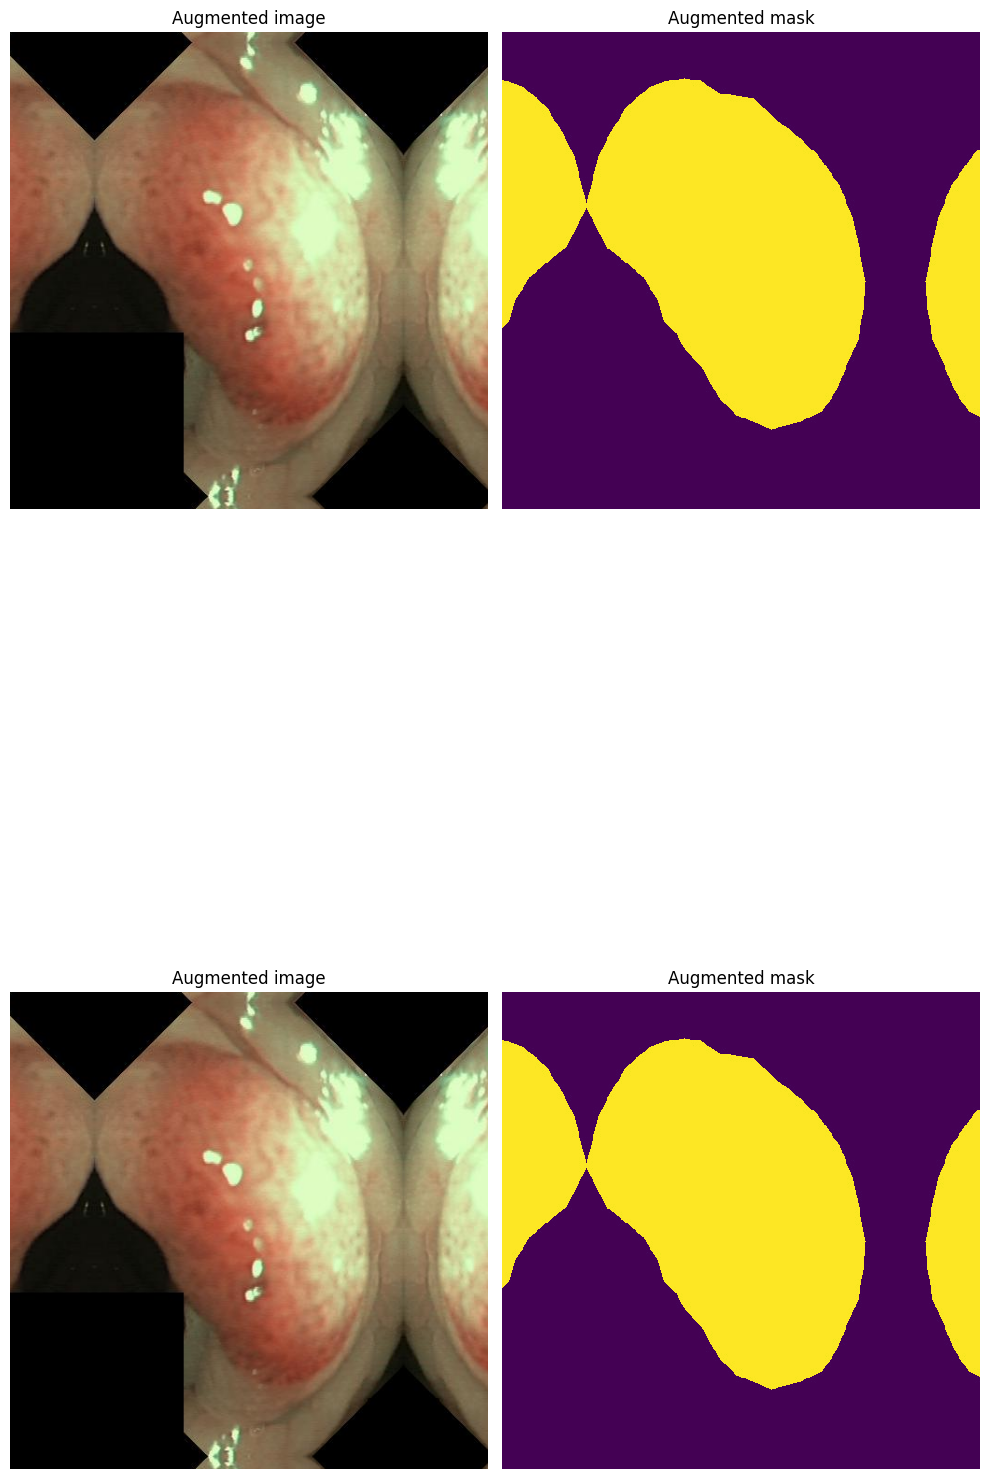

In [9]:
visualize_augmentations(ds_train, 2)

##Настраиваем параметры модели (bath_size, loss, optimizer и т.д)

In [ ]:
batch_size = 6
train_loader = torch.utils.data.DataLoader(
    ds_train, shuffle=True,
    batch_size=batch_size, num_workers=1, drop_last=True
)

device = 'cuda'
unet_model = UNet(3, 3)
unet_model = unet_model.to(device)
epoh = 1

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(unet_model.parameters(), lr=0.0001, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

##Обучаем!

In [ ]:
epochs = 26
for epoch in range(epochs):
    loss_val = 0
    acc_val = 0
    for sample in (pbar := tqdm(train_loader)):
        img, mask = sample
        img = img.to(device)
        mask = mask.expand(-1, 3, -1, -1) #Эта строка кода расширяет измерения массива "mask" до указанных размеров
        mask = mask.to(device)
        optimizer.zero_grad()

        pred = unet_model(img) #Получаем предсказания
        loss = loss_fn(pred, mask) #Считаем loss

        loss.backward() #вычисляет градиенты тензоров
        loss_item = loss.item()
        loss_val += loss_item

        optimizer.step() #применяет градиенты, вычисленные в результате вызова loss.backward(), для обновления параметров модели.

    scheduler.step()
    #pbar.set_description(f'loss: {loss_item:.5f}\tlr: {scheduler.get_last_lr}')
    print(f'{loss_val/len(train_loader)}\t lr: {scheduler.get_last_lr()}') #
    print(epoh = epoh + 1)

  0%|          | 0/166 [00:00<?, ?it/s]

0.5610011379761868	 lr: [9e-05]


  0%|          | 0/166 [00:00<?, ?it/s]

0.4998506237584424	 lr: [8.1e-05]


  0%|          | 0/166 [00:00<?, ?it/s]

0.4660974997712905	 lr: [7.290000000000001e-05]


  0%|          | 0/166 [00:00<?, ?it/s]

0.43576262729713716	 lr: [6.561000000000002e-05]


  0%|          | 0/166 [00:00<?, ?it/s]

0.41271879371390285	 lr: [5.904900000000002e-05]


  0%|          | 0/166 [00:00<?, ?it/s]

0.392379940094718	 lr: [5.314410000000002e-05]


  0%|          | 0/166 [00:00<?, ?it/s]

0.3775340476668025	 lr: [4.782969000000002e-05]


  0%|          | 0/166 [00:00<?, ?it/s]

0.35663830497896815	 lr: [4.304672100000002e-05]


  0%|          | 0/166 [00:00<?, ?it/s]

0.3480032027126795	 lr: [3.874204890000002e-05]


  0%|          | 0/166 [00:00<?, ?it/s]

0.33021137028573505	 lr: [3.4867844010000016e-05]


  0%|          | 0/166 [00:00<?, ?it/s]

0.3275956346328	 lr: [3.138105960900002e-05]


  0%|          | 0/166 [00:00<?, ?it/s]

0.309171156800655	 lr: [2.8242953648100018e-05]


  0%|          | 0/166 [00:00<?, ?it/s]

0.30391806355082845	 lr: [2.5418658283290016e-05]


  0%|          | 0/166 [00:00<?, ?it/s]

0.29453956021601896	 lr: [2.2876792454961016e-05]


  0%|          | 0/166 [00:00<?, ?it/s]

0.29491517683827734	 lr: [2.0589113209464913e-05]


  0%|          | 0/166 [00:00<?, ?it/s]

0.28177946446889857	 lr: [1.8530201888518422e-05]


  0%|          | 0/166 [00:00<?, ?it/s]

0.27757902649870836	 lr: [1.667718169966658e-05]


  0%|          | 0/166 [00:00<?, ?it/s]

0.2715675431382225	 lr: [1.5009463529699922e-05]


  0%|          | 0/166 [00:00<?, ?it/s]

0.27271060654556895	 lr: [1.350851717672993e-05]


  0%|          | 0/166 [00:00<?, ?it/s]

0.2631533022027418	 lr: [1.2157665459056937e-05]


  0%|          | 0/166 [00:00<?, ?it/s]

0.2589095907218485	 lr: [1.0941898913151244e-05]


  0%|          | 0/166 [00:00<?, ?it/s]

0.2610035039574267	 lr: [9.84770902183612e-06]


  0%|          | 0/166 [00:00<?, ?it/s]

0.2516548523163221	 lr: [8.862938119652508e-06]


  0%|          | 0/166 [00:00<?, ?it/s]

0.24565142204603516	 lr: [7.976644307687257e-06]


  0%|          | 0/166 [00:00<?, ?it/s]

0.24336705428649144	 lr: [7.1789798769185315e-06]


  0%|          | 0/166 [00:00<?, ?it/s]

0.24129868469324456	 lr: [6.461081889226678e-06]


In [61]:
###ЗАГРУЗКА МОДЕЛИ###

unet_model = torch.load('drive/MyDrive/unet_model_medical_v1.5.pth')
unet_model.load_state_dict(torch.load('drive/MyDrive/unet_wgits_medical_v1.5.pth'))

unet_model.eval()  # установить модель в режим инференса

UNet(
  (conv1): convolution_block(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): GELU(approximate='none')
  )
  (conv2): convolution_block(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

##Посмторим, насколько наша нейросеть правильно работает

In [77]:
img = ds_train[28][0].unsqueeze(0)
pred = unet_model(img.cuda())
pred = F.sigmoid(pred.detach()).cpu().numpy()[0].transpose(1,2,0)

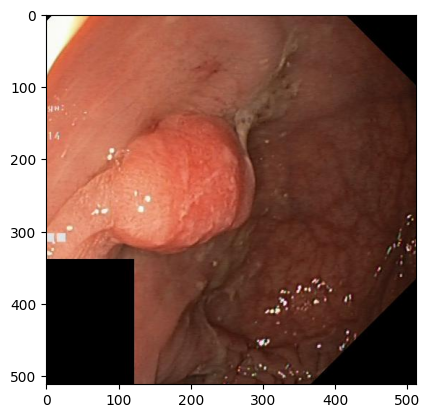

In [78]:
img_np = img.detach().cpu().numpy()[0].transpose(1,2,0)
img_np = img_np.astype(np.float32)
plt.imshow(img_np)

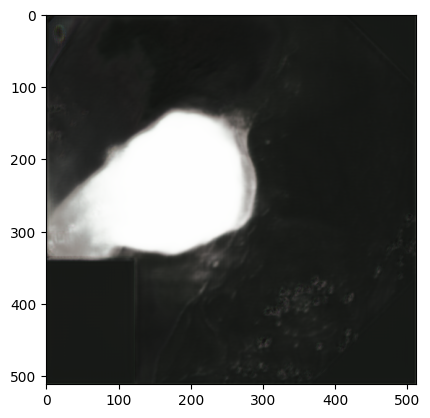

In [79]:
plt.imshow(pred)

##Сохраним модель

In [ ]:
torch.save(unet_model.state_dict(), 'drive/MyDrive/unet_wgits_medical_v1.6.pth')
torch.save(unet_model, 'drive/MyDrive/unet_model_medical_v1.6.pth')